## German wings review challenge

The goal of this notebook is to show based on the customer review data how to predict the target variable 'Recommended'.
The data is found in a text file holding a set of reviews about the German wings airline (airline code ‘4U’).


In [282]:
import collections
from collections import Counter

import math

from datetime import datetime

import statsmodels.formula.api as smf

import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype

import numpy as np
from numpy import inf

from scipy import stats
from scipy.stats import skew
from scipy.stats import randint as sp_randint
from scipy.stats import norm
from scipy import interp

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import pyplot
%matplotlib inline
import seaborn as sns

from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import label_binarize
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.utils.fixes import signature


import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

import lightgbm as lgb

from hyperopt import hp, tpe, STATUS_OK, Trials
from hyperopt.fmin import fmin

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = nltk.download('stopwords')
#stop_words = stopwords.words('english')

np.random.seed(42)

[nltk_data] Downloading package stopwords to /Users/kai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Load Data

In [188]:
# convert text data in the txt file into a pandas dataframe
def get_df_review(filename='4U_Reviews.txt', encoding = "ISO-8859-1"):
    
    #map the content to dictionary
    dict_review = {'Title':[], 
                   'User Name':[], 
                   'Country':[], 
                   'Date':[],
                   'Rating':[], 
                   'Review':[], 
                   'Type Of Traveller':[], 
                   'Cabin Flown':[], 
                   'Route':[], 
                   'Date Flown':[], 
                   'Seat Comfort':[], 
                   'Cabin Staff Service':[], 
                   'Ground Service':[], 
                   'Value For Money':[], 
                   'Recommended':[]
                  }

    other_info_names = ['Type Of Traveller', 
                        'Cabin Flown', 
                        'Route', 
                        'Date Flown', 
                        'Seat Comfort', 
                        'Cabin Staff Service', 
                        'Ground Service', 
                        'Value For Money', 
                        'Recommended'
                       ]
    
    f = open(filename, "r", encoding = encoding)
    
    review_info_list = [] 
    
    for line in f:
        if line == '\n':
            #print("-----")
            #print(review_info_list)

            # get Title, User Name, Country, Date, Rating, Review
            for i, line in enumerate(review_info_list):
                # get title
                if i == 0:
                    #print('title: {}'.format(line))
                    dict_review['Title'].append(line)
                # get user name, country, date
                elif i == 1:
                    user_name = ''
                    country_name = ''
                    date_str = ''
                    
                    pos_start = line.find('(')
                    pos_end = line.find(')')
                    if pos_start != -1:
                        user_name = line[0:pos_start].strip()
                        country_name = line[pos_start+1:pos_end].strip()
                        date_str = line[pos_end+1:].strip()
                    else:
                        str_list = line.split()
                        if len(str_list) == 5:
                            user_name = str_list[0] + ' ' + str_list[1]
                            country_name = ''
                            date_str = str_list[-3].strip() + ' ' + str_list[-2].strip() + ' ' + str_list[-1].strip()
                        
                    #print('user name: {}'.format(user_name))
                    #print('country name: {}'.format(country_name))
                    #print('date: {}'.format(date_str))
                    dict_review['User Name'].append(user_name)
                    dict_review['Country'].append(country_name)
                    dict_review['Date'].append(date_str)
                # get rating
                elif i == 2:
                    if line.strip() == 'na':
                        rating = np.nan
                    else:
                        rating = int(line.strip())
                    #print('rating: {}'.format(rating))
                    dict_review['Rating'].append(rating)
                # get review
                elif i == 3:
                    #print('review')
                    #print(line.strip())
                    dict_review['Review'].append(line.strip())
            
            # get other information     
            for info_name in other_info_names:
                review_info = ''
                for i, line in enumerate(review_info_list):
                    pos = line.find(info_name)
                    if pos != -1:
                        review_info = line[len(info_name)+1:].strip()
                        break
                dict_review[info_name].append(review_info)

            review_info_list = [] 
        else:
            line = line.replace('\"', '')
            #print(line)
            review_info_list.append(line)


    df_review = pd.DataFrame(dict_review)
    
    # get route to and route from   
    def f_from(x):
        if x:
            return x.split()[0]
        return ''
    def f_to(x):
        if x:
            return x.split()[2]
        return ''
    df_review['Route From'] = df_review['Route'].apply(f_from)
    df_review['Route To'] = df_review['Route'].apply(f_to)
    

    return df_review
            
        

In [189]:
df_review = get_df_review()

## 2. EDA

In [190]:
df_review.head()

,Cabin Flown,Cabin Staff Service,Country,Date,Date Flown,Ground Service,Rating,Recommended,Review,Route,Seat Comfort,Title,Type Of Traveller,User Name,Value For Money,Route From,Route To
0,Economy,12345,Canada,16th October 2015,September 2015,12345,2.0,no,We flew with Germanwings (or tried to) on Sept...,Stuttgart to Amsterdam,12345,they have been unresponsive\n,Couple Leisure,Brian McNamee,12345,Stuttgart,Amsterdam
1,Economy,12345,United Kingdom,4th October 2015,September 2015,12345,3.0,no,I am less than impressed with Germanwings serv...,Hamburg to London,12345,I was refused some water\n,Solo Leisure,L Mouratidou,12345,Hamburg,London
2,Economy,12345,Germany,21st September 2015,September 2015,12345,3.0,no,Flew from Palma de Mallorca to Cologne with Ge...,PMI to CGN,12345,the service crew were friendly but nothing more\n,Couple Leisure,H Mutschler,12345,PMI,CGN
3,,12345,Germany,20th September 2015,August 2015,12345,10.0,yes,Good flight from Berlin-Tegel to London Heathr...,Berlin-Tegel to London Heathrow,12345,"no problems or delays, very friendly staff\n",Business,Oliver Numrich,12345,Berlin-Tegel,London
4,Economy,12345,Germany,14th September 2015,September 2015,12345,4.0,no,I don't get why Germanwings is always late and...,CGN to LHR,12345,I don't get why Germanwings is always late\n,Business,Andreas Huettenhoelscher,12345,CGN,LHR


In [191]:
df_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 17 columns):
Cabin Flown            127 non-null object
Cabin Staff Service    127 non-null object
Country                127 non-null object
Date                   127 non-null object
Date Flown             127 non-null object
Ground Service         127 non-null object
Rating                 114 non-null float64
Recommended            127 non-null object
Review                 127 non-null object
Route                  127 non-null object
Seat Comfort           127 non-null object
Title                  127 non-null object
Type Of Traveller      127 non-null object
User Name              127 non-null object
Value For Money        127 non-null object
Route From             127 non-null object
Route To               127 non-null object
dtypes: float64(1), object(16)
memory usage: 16.9+ KB


In [192]:
df_review.shape

(127, 17)

### 2.1 Analyse target 'Recommended' 

In [193]:
df_review['Recommended'].describe()

count     127
unique      2
top        no
freq       65
Name: Recommended, dtype: object

In [194]:
df_review['Recommended'].unique()

array(['no', 'yes'], dtype=object)

In [195]:
df_review['Recommended'].isnull().sum()

0

In [197]:
# Transfer string into integer

lbl_enc = preprocessing.LabelEncoder()
df_review['Recommended Label'] = lbl_enc.fit_transform(df_review['Recommended'].values)

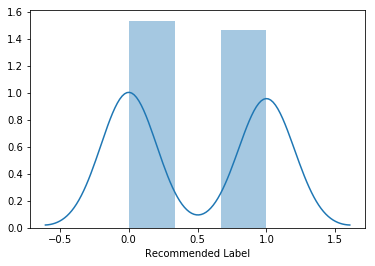

In [199]:
sns.distplot(df_review['Recommended Label'])

In [200]:
df_review[df_review['Recommended Label'] == 1].shape

(62, 18)

In [201]:
df_review[df_review['Recommended Label'] == 0].shape

(65, 18)

### 2.2 Analyse target 'Rating' 

In [205]:
df_review['Rating'].describe()

count    114.000000
mean       5.587719
std        2.874395
min        1.000000
25%        3.000000
50%        5.000000
75%        8.000000
max       10.000000
Name: Rating, dtype: float64

In [218]:
df_review[df_review['Rating'].notnull()].shape

(114, 18)

In [219]:
df_review.shape

(127, 18)

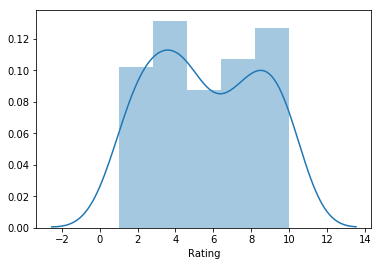

In [220]:
sns.distplot(df_review[df_review['Rating'].notnull()]['Rating'])

### 2.3 Missing Data

In [221]:
total = df_review.isnull().sum().sort_values(ascending=False)
percent = (df_review.isnull().sum()/df_review.count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
# missing_data.head(20)
missing_data

,Total,Percent
Rating,13,0.114035
Recommended Label,0,0.000000
Route To,0,0.000000
Cabin Staff Service,0,0.000000
Country,0,0.000000
Date,0,0.000000
Date Flown,0,0.000000
Ground Service,0,0.000000
Recommended,0,0.000000
Review,0,0.000000


It shows that 10% of the customer does not rate the flights.

### 2.4 Show relationship between 'Recommended' and other variables

- Relationship with numerical variables

In [222]:
def show_relation_numerical(df, var, target):
    data = pd.concat([df[target], df[var]], axis=1)
    data.plot.scatter(x=var, y=target)

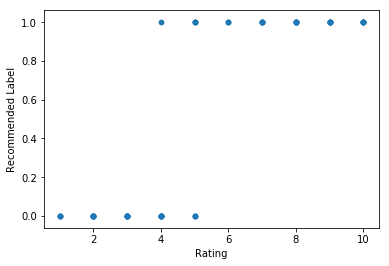

In [223]:
num_vars = ['Rating']

for num_var in num_vars:
    show_relation_numerical(df_review, num_var, 'Recommended Label')

It shows that 'Rating' is an important feature to distinguish the target variable 'Recommended'.

- Relationship with categorical features

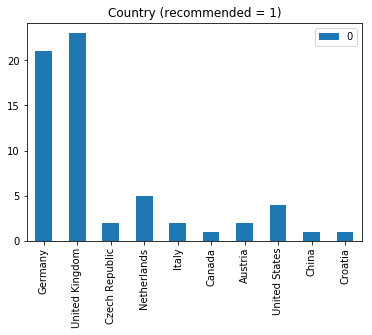

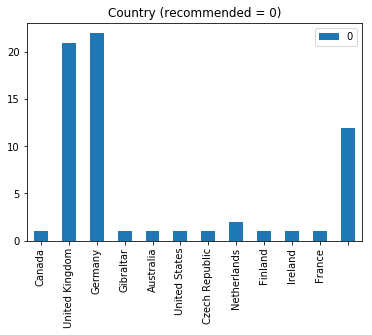

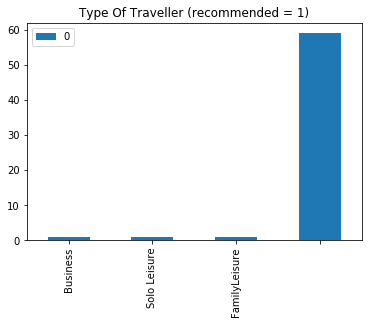

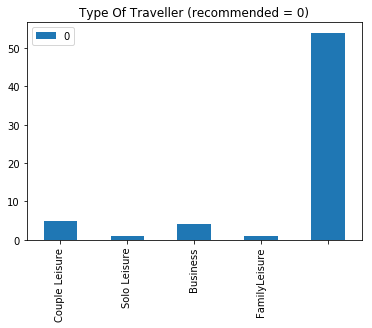

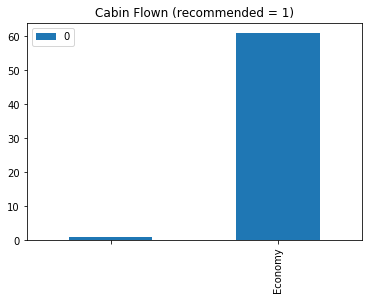

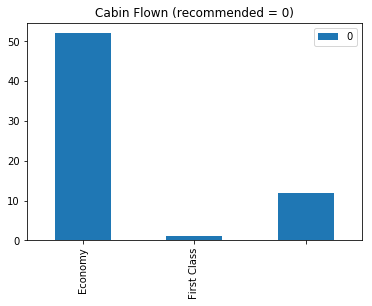

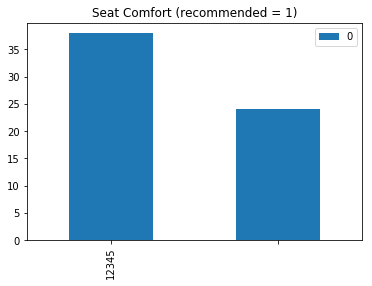

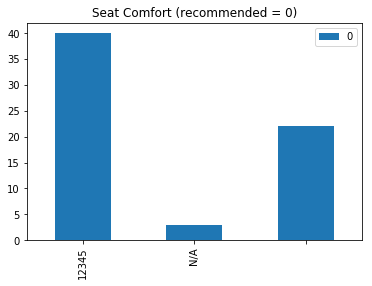

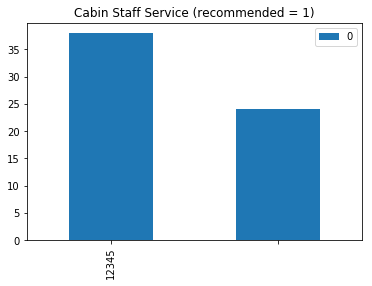

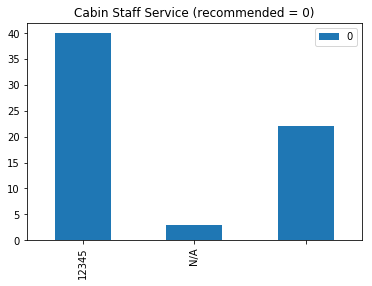

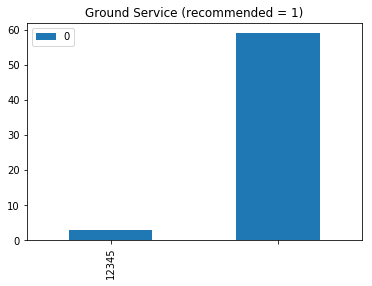

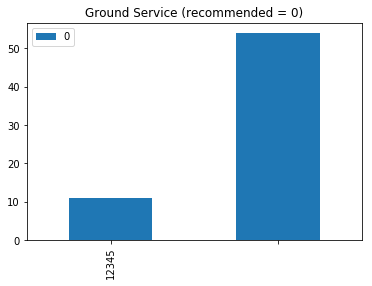

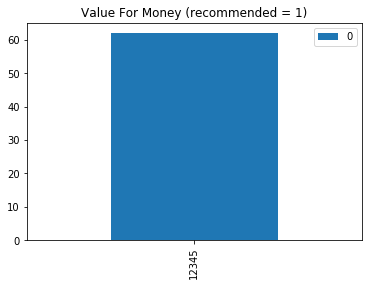

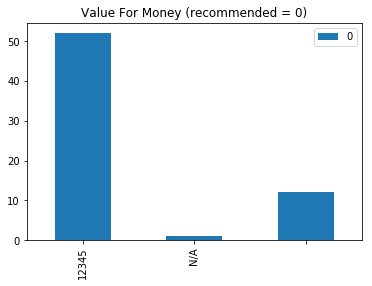

In [224]:
cat_vars = ['Country', 'Type Of Traveller', 'Cabin Flown', 'Seat Comfort', 'Cabin Staff Service', 'Ground Service', 'Value For Money']
                  
# https://stackoverflow.com/questions/28418988/how-to-make-a-histogram-from-a-list-of-strings-in-python
def plot_strings(a, title=''):
    letter_counts = Counter(a)
    df = pd.DataFrame.from_dict(letter_counts, orient='index')
    df.plot(kind='bar', title=title)

    
for cat_var in cat_vars:
    df = df_review[df_review['Recommended Label'] == 1][[cat_var]]
    plot_strings(df[cat_var].tolist(), title=cat_var+' (recommended = 1)')
    
    df = df_review[df_review['Recommended Label'] == 0][[cat_var]]
    plot_strings(df[cat_var].tolist(), title=cat_var+' (recommended = 0)')
    

It shows that there is a lot of missing data in the categorical features. The categorical features are not usefull to predict target variable 'Recommended'.

### 2.5 Text analysis

Reference:
https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle

- Title

In [225]:
df_review['Title'].unique()

array(['they have been unresponsive\n', 'I was refused some water\n',
       'the service crew were friendly but nothing more\n',
       'no problems or delays, very friendly staff\n',
       "I don't get why Germanwings is always late\n",
       'vowing never to book Germanwings again\n',
       'staff friendly - food terrible\n',
       'no explanations, no offers of help\n',
       'delay in Heathrow about 1:30 minutes\n',
       'Germanwings customer review\n'], dtype=object)

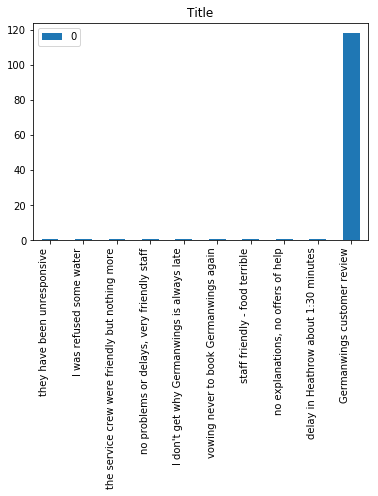

In [226]:
plot_strings(df_review['Title'], title='Title')

It shows that most of the reviews have the title 'Germanwings customer review'. Therefore, I will not use 'Title' as a feature to predict 'Recommended'

- TODO: Review

## 3. Modelling

The recommendation problem is formulated into a binary classification problem, i.e., classify the text data (review) into recommended and non-recommended.

- Define evaluation metric
Kaggle has specified multi-class log-loss as evaluation metric. 
This is implemented in the follow way 
taken from: 
https://github.com/dnouri/nolearn/blob/master/nolearn/lasagne/util.py)
https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle

In [186]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota



- Plot precision recall curve

https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py

In [252]:

def plot_pr_curve(y_test, y_score):
    average_precision = average_precision_score(y_test, y_score)
    
    #print('Average precision-recall score: {0:0.2f}'.format(average_precision))

    precision, recall, _ = precision_recall_curve(y_test, y_score)
    
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

- Plot AUC curve

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

https://qiita.com/bmj0114/items/460424c110a8ce22d945

In [279]:
def plot_auc_curve(y_test, y_score):
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

- Prepare data sets

In [228]:
y = df_review['Recommended Label']

In [229]:
xtrain, xvalid, ytrain, yvalid = train_test_split(df_review['Review'].values, 
                                                  y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.2, 
                                                  shuffle=True)

In [230]:
print (xtrain.shape)
print (xvalid.shape)

(101,)
(26,)


- Basic Models

The first model is a TF-IDF (Term Frequency - Inverse Document Frequency) followed by a simple Logistic Regression.

In [231]:
tfv = TfidfVectorizer(min_df=3,  
                      max_features=None, 
                      strip_accents='unicode', 
                      analyzer='word',
                      token_pattern=r'\w{1,}',
                      ngram_range=(1, 3), 
                      use_idf=1,
                      smooth_idf=1,
                      sublinear_tf=1,
                      stop_words = 'english',
                     )

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(xtrain) + list(xvalid))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)

In [263]:
# Fitting a simple Logistic Regression on TFIDF
clf = LogisticRegression()
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)
ypred = clf.predict(xvalid_tfv)

- Report performance

In [264]:
print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.611 


- Plot Precision Recall curve

    - Precision-Recall curves summarize the trade-off between the **true positive rate** and the **positive predictive value** for a predictive model using different probability thresholds.
    - Precision-Recall curves are appropriate for imbalanced datasets, whereas ROC curves are appropriate when the observations are balanced between each class.

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/



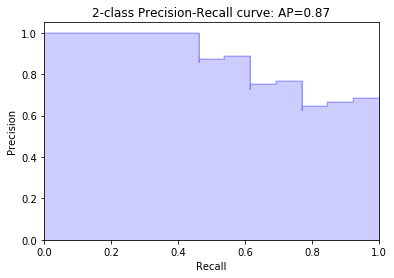

In [265]:
plot_pr_curve(yvalid, predictions[:, 1])

In [267]:
print(classification_report(yvalid.values, ypred))

             precision    recall  f1-score   support

          0       0.75      0.69      0.72        13
          1       0.71      0.77      0.74        13

avg / total       0.73      0.73      0.73        26



- Plot ROC curve

    - ROC Curves summarize the trade-off between the **true positive rate** and **false positive rate** for a predictive model using different probability thresholds.
    
    - ROC curves are appropriate when the observations are balanced between each class, whereas precision-recall curves are appropriate for imbalanced datasets.

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

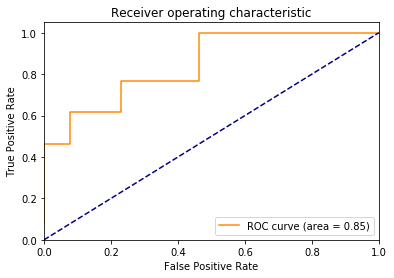

In [280]:
plot_auc_curve(yvalid, predictions[:, 1])

In [283]:
roc_auc_score(yvalid, predictions[:, 1])

0.8461538461538461

- Error analysis

In [313]:
def get_error_pred(yvalid, ypred):
    """
    Generate a dataframe contains the missclassified data
    """
    index_error = yvalid != ypred
    x_error = xvalid[index_error]
    ytrue_error = yvalid[index_error].values
    ypred_error = ypred[index_error]
    
    df_error = pd.DataFrame({'x':x_error, 'y_true':ytrue_error, 'y_pred':ypred_error})
    
    return df_error

In [314]:
df_error = get_error_pred(yvalid, ypred)

In [319]:
for index, row in df_error.iterrows():
    print('index: {}'.format(index))
    print(row['x'])
    print('true label: {}'.format(row['y_true']))
    print('\n')

index: 0
Booked Lufthansa flight Cologne-Berlin on 28 Jan. On 2 Jan I got the information that the flight was operated by Germanwings a German low-cost carrier. So was the flight. Low cost: 1 hrs delayed for my beer I had to pay in Euros - cash. Lounge use was denied as the flight was operated under 4U code. No service for a high Lufthansa price. Not recommended very disappointed.
true label: 0


index: 1
First time I have used Germanwings for connecting flights (via Hamburg). The APP does not work properly. They are unable to issue both boarding cards on check in causing unnecessary inconvenience. Their Live Twitter response averages 24 hours to reply. Cabin crew spend most time behind front galley curtains. Also fail to do proper cabin secure checks prior to landing. Seats new ultra thin models OK for short flights. Seat pitch OK on the extra space seats. Smart fare snack boring and repetitive. They have taken over a lot of Lufthansa routes and to be honest they are not really geared

Review 2 is not clear for me it was positive or negative.
Reviews 4, 5 has some pros and cons.
Reviews 3, 6 could be neutral.